## Download dataset

In [2]:
import opendatasets as od

In [3]:
od.download('https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection')

Skipping, found downloaded files in "./brain-mri-images-for-brain-tumor-detection" (use force=True to force download)


##Explore dataset

In [4]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
## How many images?
DATA_DIR = '/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
for root,_,files in os.walk(DATA_DIR):
  print(root,'have',len(files),'images')

/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset have 0 images
/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/no have 98 images
/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes have 155 images


#### visualizing some images and seeing some informations like:
  * Dtype
  * shape
  * min / max value

Image shape (without tumor):(340, 339, 3)
Image dtype (without tumor):uint8
Image min/max value (without tumor):(0, 255)

Image shape (with tumor):(290, 250, 3)
Image dtype (with tumor):uint8
Image min/max value (with tumor):(0, 255)


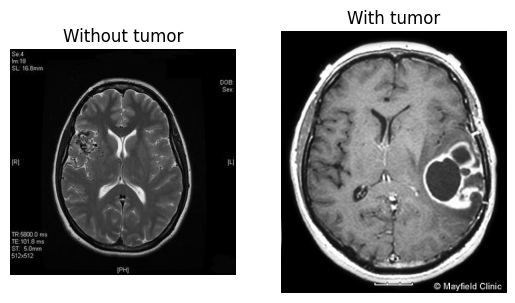

In [6]:
class_no = '/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/no'
class_yes = '/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes'

random_img_no = random.choice(os.listdir(class_no))
random_img_yes = random.choice(os.listdir(class_yes))

img_path_no = os.path.join(class_no, random_img_no)
img_path_yes = os.path.join(class_yes, random_img_yes)

img_no = mpimg.imread(img_path_no)
img_yes = mpimg.imread(img_path_yes)
print(f'Image shape (without tumor):{img_no.shape}\nImage dtype (without tumor):{img_no.dtype}\nImage min/max value (without tumor):{img_no.min(),img_no.max()}')
print(f'\nImage shape (with tumor):{img_yes.shape}\nImage dtype (with tumor):{img_yes.dtype}\nImage min/max value (with tumor):{img_yes.min(),img_yes.max()}')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_no)
plt.title('Without tumor')
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(img_yes)
plt.title('With tumor')
plt.axis(False)
plt.show()

## Load dataset

In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [8]:
train_data,test_data=image_dataset_from_directory(DATA_DIR,
                                                  batch_size=None,
                                                  image_size=(224,224),
                                                  seed=42,
                                                  validation_split=0.3,
                                                  subset='both')

Found 253 files belonging to 2 classes.
Using 178 files for training.
Using 75 files for validation.


##Preprocess images

In [9]:
import tensorflow as tf

In [10]:
def preprocess_img(image, label):
  return tf.cast(image, tf.float32), label

In [11]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
train_data, test_data

(<_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>)

In [13]:
train_dataset = train_data.batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = test_data.batch(16).prefetch(tf.data.AUTOTUNE)

# Feature extraction model with a pretrained model efficient net

In [14]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [15]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

In [16]:
inputs = layers.Input(shape=(224,224,3), dtype=tf.float32)
x = base_model(inputs, training=False)
x = layers.Dense(8)(x)
x = layers.GlobalAveragePooling2D()(x)
outputs=layers.Dense(1, activation='sigmoid')(x)
model_0 = tf.keras.Model(inputs, outputs)

In [17]:
model_0.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [18]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 dense (Dense)               (None, 7, 7, 8)           10248     
                                                                 
 global_average_pooling2d (  (None, 8)                 0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5929569 (22.62 MB)
Trainable params: 10257 (40.

In [19]:
model_0_history = model_0.fit(train_dataset,
                              epochs=5,
                              validation_data=test_dataset,
                              steps_per_epoch=len(train_dataset),
                              validation_steps=int(0.2*len(test_dataset)))#validates on 20%of test data

Epoch 1/5
12/12 [==============================] - 28s 1s/step - loss: 0.7229 - accuracy: 0.6180 - val_loss: 0.4843 - val_accuracy: 0.8125
Epoch 2/5
12/12 [==============================] - 11s 926ms/step - loss: 0.4940 - accuracy: 0.7865 - val_loss: 0.5356 - val_accuracy: 0.6875
Epoch 3/5
12/12 [==============================] - 11s 938ms/step - loss: 0.3774 - accuracy: 0.8146 - val_loss: 0.3713 - val_accuracy: 0.8750
Epoch 4/5
12/12 [==============================] - 11s 923ms/step - loss: 0.3246 - accuracy: 0.8820 - val_loss: 0.4005 - val_accuracy: 0.8750
Epoch 5/5
12/12 [==============================] - 11s 947ms/step - loss: 0.2770 - accuracy: 0.8989 - val_loss: 0.3681 - val_accuracy: 0.8750


## Evaluating the model without fine-tune

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
import numpy as np

In [21]:
## making some preds
y_pred_probs = model_0.predict(test_dataset)
y_pred=tf.squeeze(tf.round(y_pred_probs))

5/5 [==============================] - 6s 726ms/step


In [22]:
#getting the true labels
y_true=[]
for _,label in test_dataset.unbatch():
  y_true.append(label)
y_true=np.array(y_true)

Accuracy:90.67%


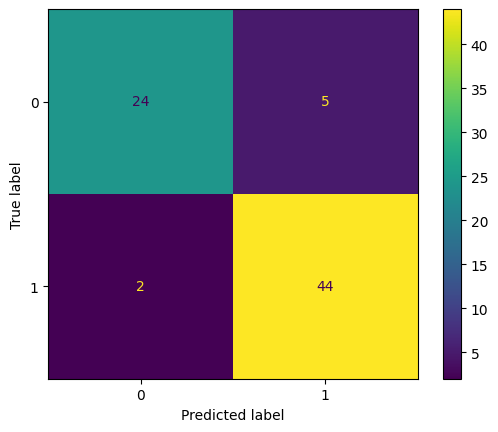

              precision    recall  f1-score   support

           0       0.92      0.83      0.87        29
           1       0.90      0.96      0.93        46

    accuracy                           0.91        75
   macro avg       0.91      0.89      0.90        75
weighted avg       0.91      0.91      0.91        75



In [25]:
print(f'Accuracy:{accuracy_score(y_true, y_pred)*100:.2f}%')
cm = confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_true, y_pred))